This is an example of a jupyter notebook, running using the `pixi` environment we created to manage our dependencies. Note that you may need to change your python interpreter (top right corner) to:
`.pixi/envs/default/bin/python`

In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
import torch

import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score

# import opensoundscape
# from opensoundscape import Audio, Spectrogram

import bioacoustics_model_zoo as bmz
from opensoundscape.ml.shallow_classifier import (
    MLPClassifier,
    quick_fit,
    fit_classifier_on_embeddings
)

from scipy.special import softmax
# from matplotlib import pyplot as plt
from collections import defaultdict
import torch.nn.functional as F
# from tqdm import tqdm

2025-03-28 22:29:17.908589: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### ALL STUFF BELOW NEEDS TO BE VERIFIED :) ###

In [2]:
# All DataFrames
datapath = "data/audio"
species_list = ["bullfrog", "coyote", 'noise']

datatype = "data"

# Format of the original Data
# audio
# - bullfrog
#   - data
#       - pos
#       - neg
# - coyote
#   - data
#      - pos 
# '/workspaces/non-avian-ml-toy/data/audio/bullfrog/data/neg/bullfrog-neg-t-11113588_9.wav' # Following this format
# Creating a dataframe for each animal species with file paths and labels

df_each_species = defaultdict(list) # Create a dictionary to hold dataframes for each species

# Note Can also use OneHotEncoder in Sckit-learn
all_species = pd.DataFrame()
for species in species_list:

    # Files Paths
    pos_files = glob.glob(os.path.join(datapath, species, datatype, "pos", "*.wav")) # List of species pos files
    neg_files = glob.glob(os.path.join(datapath, species, datatype, "neg", "*.wav")) # List of species neg files
    all_files = pos_files + neg_files # Combine all file paths

    # Encoding
    pos_files_init = [1] * len(pos_files) # List of 1s for each positive file
    neg_files_init = [0] * len(neg_files) # List of 0s for each negative file
    encoding_pos_files = pos_files_init + neg_files_init
    encoding_neg_files = neg_files_init + pos_files_init

    pd_each_species = pd.DataFrame({'files': all_files, species: encoding_pos_files, 'noise': encoding_neg_files})
    df_each_species[species] = pd_each_species

for species in species_list:
    all_species = pd.concat([all_species, df_each_species[species]], axis=0) # Combinting each species df to one

# Fill NaN values with 0, set index, convert to int
all_species.fillna(0, inplace=True)  # Replace NaN values with 0
all_species.set_index("files", inplace=True)  # Set 'files' as the index
all_species = all_species.astype(int)  # Convert to int

# Optionally putting other in the last Row
if True:
    other_col = all_species.pop("noise")
    all_species.insert(len(all_species.columns), "noise", other_col)

# Creating a mapping from index to species and vice versa
idx_to_all_species = {i: col for i, col in enumerate(all_species.columns)}
all_species_to_idx = {value: key for key, value in idx_to_all_species.items()}

# Creating a one-hot encoded dataframe for labels
ohe_df_all = all_species.copy()

# All Species with there labels
all_species['labels'] = ohe_df_all.iloc[:, :].idxmax(axis=1)
all_species = all_species[['labels']]

In [3]:
# Printing the DF's available
print('ohe_df_all')
display(ohe_df_all.head(2))
print('all_species')
display(all_species.head(2))

all_species.reset_index().head(1)
numerical_all_species = all_species.copy()
numerical_all_species["labels"] = numerical_all_species["labels"].map(all_species_to_idx)

print('numerical_all_species')
display(numerical_all_species.head(2))

print("df_each_species['coyote']")
display(df_each_species['coyote'].head(2))


print(f'"all_species_to_idx" -> {all_species_to_idx}')
print(f'"idx_to_all_species" -> {idx_to_all_species}') 
print(f'"df_each_species [name of species: df of that species] -> {df_each_species.keys()}')


ohe_df_all


,bullfrog,coyote,noise
files,,,
data/audio/bullfrog/data/pos/bullfrog-pos-t-11113588_147.wav,1,0,0
data/audio/bullfrog/data/pos/bullfrog-pos-t-11113588_144.wav,1,0,0


all_species


,labels
files,
data/audio/bullfrog/data/pos/bullfrog-pos-t-11113588_147.wav,bullfrog
data/audio/bullfrog/data/pos/bullfrog-pos-t-11113588_144.wav,bullfrog


numerical_all_species


,labels
files,
data/audio/bullfrog/data/pos/bullfrog-pos-t-11113588_147.wav,0
data/audio/bullfrog/data/pos/bullfrog-pos-t-11113588_144.wav,0


df_each_species['coyote']


,files,coyote,noise
0,data/audio/coyote/data/pos/coyote-pos-t-110319...,1,0
1,data/audio/coyote/data/pos/coyote-pos-t-110319...,1,0


"all_species_to_idx" -> {'bullfrog': 0, 'coyote': 1, 'noise': 2}
"idx_to_all_species" -> {0: 'bullfrog', 1: 'coyote', 2: 'noise'}
"df_each_species [name of species: df of that species] -> dict_keys(['bullfrog', 'coyote', 'noise'])


In [4]:
# Getting Data on Number of Each Species
for species in species_list:
    total = ohe_df_all[species].sum()
    print(f"Total {species} samples: {total}")

Total bullfrog samples: 15
Total coyote samples: 15
Total noise samples: 30


In [5]:
# Stuff as initializaion
torch.manual_seed(8)
random.seed(8)
np.random.seed(8)

# Use maximum CPUs for your device
num_workers = os.cpu_count() * 3 // 4  # Use 75% of cores

In [6]:
#%%capture # This line truncates the output
# https://github.com/kitzeslab/bioacoustics-model-zoo/blob/main/bioacoustics_model_zoo/perch.py
bmz.utils.list_models() # might be helpful

model = bmz.BirdNET()

File BirdNET_GLOBAL_6K_V2.4_Labels_af.txt already exists; skipping download.
downloading model from URL...
File BirdNET_GLOBAL_6K_V2.4_Model_FP16.tflite already exists; skipping download.


/opt/conda/lib/python3.12/site-packages/opensoundscape/ml/cnn.py:599: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to register the generating function.

                    The function can also set the returned object's .constructor_name to the registered string key in ARCH_DICT
                    to avoid this warning and ensure it is reloaded correctly by opensoundscape.ml.load_model().

                    See opensoundscape.ml.cnn_architectures module for examples of constructor functions
                    
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/opens

In [7]:
# Stratified K Fold on one species at a time seperately. (Binary: Species or Noise) 
def stratified_k_fold_one_species(validates_species, fold_num=3, num_workers=num_workers):
    all_roc_auc_scores = defaultdict(list)
    for species in validates_species:
        curr_df = df_each_species[species]  # Full dataset

        file_paths = curr_df['files']  # File paths
        labels = curr_df[species]  # Binary classification (0 or 1)

        # Define number of folds
        fold_num = fold_num
        skf = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=8)

        ROC_AUC_scores = []

        # Perform Stratified K-Fold
        for fold_idx, (train_idx, test_idx) in enumerate(skf.split(file_paths, labels)):  
            train_files, test_files = file_paths.iloc[train_idx].tolist(), file_paths.iloc[test_idx].tolist()
            labels_train, labels_val = labels.iloc[train_idx], labels.iloc[test_idx]

            # Reshape labels to match the model output shape
            labels_train = labels_train.to_numpy().reshape(-1, 1)  
            labels_val = labels_val.to_numpy().reshape(-1, 1)  

            # Generate embeddings for training and validation sets
            emb_train = model.embed(train_files, return_dfs=False, batch_size=4, num_workers=num_workers)
            emb_val = model.embed(test_files, return_dfs=False, batch_size=4, num_workers=num_workers)

            # Define class for training (only "bullfrog")
            classes = [species]
            model.change_classes(classes)

            # Fit the classification head with embeddings and labels
            model.network.fit(emb_train, labels_train, emb_val, labels_val)

            logits = model.network(torch.tensor(emb_val)).detach() # Return raws logits of predictions not the preds
            probs = F.sigmoid(logits).detach().numpy()  # Use sigmoid for binary classifcation
            
            # Calculate the area under the ROC score
            curr_score = roc_auc_score(labels_val, probs, average=None) 
            ROC_AUC_scores.append(curr_score)

            # Plot histogram of predictions
            # preds = preds.detach().numpy()
            # plt.hist(preds[labels_val == 1], bins=20, alpha=0.5, label='Bullfrog Present')
            # plt.hist(preds[labels_val == 0], bins=20, alpha=0.5, label='Bullfrog Absent')
            # plt.title(f"Fold {fold_idx + 1}")
            # plt.legend()
            # plt.show()

            # Print Fold Information
            # print('---------------------------')
            # print(f"Current Fold: {fold_idx + 1}")
            # print(f"ROC AUC Score: {curr_score}\n")
        all_roc_auc_scores[species] = ROC_AUC_scores
    return all_roc_auc_scores


In [8]:
#%%capture # Hides output
validates_species = ['coyote', 'bullfrog'] # Choose which species to validate one at a time
each_roc_auc_scores = stratified_k_fold_one_species(validates_species)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Epoch 100/1000, Loss: 0.021417012438178062, Val Loss: 0.5251684784889221
val AU ROC: 0.800
val MAP: 0.710
Epoch 200/1000, Loss: 0.008512916043400764, Val Loss: 0.597655177116394
val AU ROC: 0.840
val MAP: 0.810
Epoch 300/1000, Loss: 0.004798862151801586, Val Loss: 0.6473239660263062
val AU ROC: 0.840
val MAP: 0.810
Epoch 400/1000, Loss: 0.00315060093998909, Val Loss: 0.6851857900619507
val AU ROC: 0.840
val MAP: 0.810
Epoch 500/1000, Loss: 0.0022552793379873037, Val Loss: 0.7159001231193542
val AU ROC: 0.840
val MAP: 0.810
Epoch 600/1000, Loss: 0.0017069311579689384, Val Loss: 0.7418340444564819
val AU ROC: 0.840
val MAP: 0.810
Epoch 700/1000, Loss: 0.001343211275525391, Val Loss: 0.7643507719039917
val AU ROC: 0.840
val MAP: 0.810
Epoch 800/1000, Loss: 0.001087852637283504, Val Loss: 0.784305214881897
val AU ROC: 0.840
val MAP: 0.810
Epoch 900/1000, Loss: 0.000900654005818069, Val Loss: 0.8022696375846863
val AU ROC: 0.840
val MAP: 0.810
Epoch 1000/1000, Loss: 0.000758824753575027, Va

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Epoch 100/1000, Loss: 0.026592010632157326, Val Loss: 0.3088451027870178
val AU ROC: 1.000
val MAP: 1.000
Epoch 200/1000, Loss: 0.010363266803324223, Val Loss: 0.31071990728378296
val AU ROC: 1.000
val MAP: 1.000
Epoch 300/1000, Loss: 0.005808473564684391, Val Loss: 0.31599292159080505
val AU ROC: 1.000
val MAP: 1.000
Epoch 400/1000, Loss: 0.0038035206962376833, Val Loss: 0.3211313784122467
val AU ROC: 1.000
val MAP: 1.000
Epoch 500/1000, Loss: 0.0027186579536646605, Val Loss: 0.3257978856563568
val AU ROC: 1.000
val MAP: 1.000
Epoch 600/1000, Loss: 0.0020557246170938015, Val Loss: 0.3300114870071411
val AU ROC: 1.000
val MAP: 1.000
Epoch 700/1000, Loss: 0.0016167161520570517, Val Loss: 0.3338395953178406
val AU ROC: 1.000
val MAP: 1.000
Epoch 800/1000, Loss: 0.0013088179985061288, Val Loss: 0.33734622597694397
val AU ROC: 1.000
val MAP: 1.000
Epoch 900/1000, Loss: 0.0010832679690793157, Val Loss: 0.340584933757782
val AU ROC: 1.000
val MAP: 1.000
Epoch 1000/1000, Loss: 0.0009124038042

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Epoch 100/1000, Loss: 0.032425880432128906, Val Loss: 0.0747096911072731
val AU ROC: 1.000
val MAP: 1.000
Epoch 200/1000, Loss: 0.012469440698623657, Val Loss: 0.04543272778391838
val AU ROC: 1.000
val MAP: 1.000
Epoch 300/1000, Loss: 0.0069590406492352486, Val Loss: 0.03407055884599686
val AU ROC: 1.000
val MAP: 1.000
Epoch 400/1000, Loss: 0.0045473650097846985, Val Loss: 0.027832701802253723
val AU ROC: 1.000
val MAP: 1.000
Epoch 500/1000, Loss: 0.0032462538219988346, Val Loss: 0.023816952481865883
val AU ROC: 1.000
val MAP: 1.000
Epoch 600/1000, Loss: 0.0024526789784431458, Val Loss: 0.0209798663854599
val AU ROC: 1.000
val MAP: 1.000
Epoch 700/1000, Loss: 0.0019277812680229545, Val Loss: 0.01884910836815834
val AU ROC: 1.000
val MAP: 1.000
Epoch 800/1000, Loss: 0.001559886266477406, Val Loss: 0.017178133130073547
val AU ROC: 1.000
val MAP: 1.000
Epoch 900/1000, Loss: 0.0012906662886962295, Val Loss: 0.01582488790154457
val AU ROC: 1.000
val MAP: 1.000
Epoch 1000/1000, Loss: 0.00108

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Epoch 100/1000, Loss: 0.019623812288045883, Val Loss: 0.13178661465644836
val AU ROC: 1.000
val MAP: 1.000
Epoch 200/1000, Loss: 0.00782805122435093, Val Loss: 0.11879052221775055
val AU ROC: 1.000
val MAP: 1.000
Epoch 300/1000, Loss: 0.004416719079017639, Val Loss: 0.11586866527795792
val AU ROC: 1.000
val MAP: 1.000
Epoch 400/1000, Loss: 0.0029009110294282436, Val Loss: 0.11541150510311127
val AU ROC: 1.000
val MAP: 1.000
Epoch 500/1000, Loss: 0.0020769238471984863, Val Loss: 0.1158439889550209
val AU ROC: 1.000
val MAP: 1.000
Epoch 600/1000, Loss: 0.001572179258801043, Val Loss: 0.11665221303701401
val AU ROC: 1.000
val MAP: 1.000
Epoch 700/1000, Loss: 0.0012373236240819097, Val Loss: 0.11762869358062744
val AU ROC: 1.000
val MAP: 1.000
Epoch 800/1000, Loss: 0.0010021536145359278, Val Loss: 0.11867909133434296
val AU ROC: 1.000
val MAP: 1.000
Epoch 900/1000, Loss: 0.0008298218017444015, Val Loss: 0.11975610256195068
val AU ROC: 1.000
val MAP: 1.000
Epoch 1000/1000, Loss: 0.000699106

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Epoch 100/1000, Loss: 0.022828832268714905, Val Loss: 0.04805035516619682
val AU ROC: 1.000
val MAP: 1.000
Epoch 200/1000, Loss: 0.009079016745090485, Val Loss: 0.028460517525672913
val AU ROC: 1.000
val MAP: 1.000
Epoch 300/1000, Loss: 0.005115339998155832, Val Loss: 0.020777510479092598
val AU ROC: 1.000
val MAP: 1.000
Epoch 400/1000, Loss: 0.0033572178799659014, Val Loss: 0.016566280275583267
val AU ROC: 1.000
val MAP: 1.000
Epoch 500/1000, Loss: 0.0024025205057114363, Val Loss: 0.013869807124137878
val AU ROC: 1.000
val MAP: 1.000
Epoch 600/1000, Loss: 0.0018180578481405973, Val Loss: 0.011978237889707088
val AU ROC: 1.000
val MAP: 1.000
Epoch 700/1000, Loss: 0.0014304867945611477, Val Loss: 0.010568572208285332
val AU ROC: 1.000
val MAP: 1.000
Epoch 800/1000, Loss: 0.0011584371095523238, Val Loss: 0.009472101926803589
val AU ROC: 1.000
val MAP: 1.000
Epoch 900/1000, Loss: 0.0009590664994902909, Val Loss: 0.008591325022280216
val AU ROC: 1.000
val MAP: 1.000
Epoch 1000/1000, Loss: 

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Epoch 100/1000, Loss: 0.025207990780472755, Val Loss: 0.06388747692108154
val AU ROC: 1.000
val MAP: 1.000
Epoch 200/1000, Loss: 0.009937960654497147, Val Loss: 0.03574202582240105
val AU ROC: 1.000
val MAP: 1.000
Epoch 300/1000, Loss: 0.005585190374404192, Val Loss: 0.025108063593506813
val AU ROC: 1.000
val MAP: 1.000
Epoch 400/1000, Loss: 0.003661584807559848, Val Loss: 0.019447412341833115
val AU ROC: 1.000
val MAP: 1.000
Epoch 500/1000, Loss: 0.002618906321004033, Val Loss: 0.015909114852547646
val AU ROC: 1.000
val MAP: 1.000
Epoch 600/1000, Loss: 0.001981159206479788, Val Loss: 0.013477057218551636
val AU ROC: 1.000
val MAP: 1.000
Epoch 700/1000, Loss: 0.0015585029032081366, Val Loss: 0.011696442030370235
val AU ROC: 1.000
val MAP: 1.000
Epoch 800/1000, Loss: 0.001261924160644412, Val Loss: 0.010333037935197353
val AU ROC: 1.000
val MAP: 1.000
Epoch 900/1000, Loss: 0.0010446087690070271, Val Loss: 0.009252984076738358
val AU ROC: 1.000
val MAP: 1.000
Epoch 1000/1000, Loss: 0.000

In [9]:
# Average ROC AUC score across all folds (FOR BINARY STRATIFIED K FOLD)

# Average ROC AUC for each species
def average_roc_auc_scores(species, all_roc_auc_scores):
    return np.mean(all_roc_auc_scores[species])

# Print ROC AUC for each fold and average across all folds
def roc_auc_folds(species, all_roc_auc_scores):
    for i, score in enumerate(all_roc_auc_scores[species]):
        print(f"Fold {i + 1}: ROC AUC Score = {score}")
    return (f'Average Across All folds: {average_roc_auc_scores(species, all_roc_auc_scores)}')

# Combining top 2 function and printing for every species
def all_species_roc_auc_folds(all_roc_auc_scores):
    for species in all_roc_auc_scores:
        print(species)
        print(f"{roc_auc_folds(species, all_roc_auc_scores)}")
        print('------------------------------------------------')


all_species_roc_auc_folds(each_roc_auc_scores)


coyote
Fold 1: ROC AUC Score = 0.8400000000000001
Fold 2: ROC AUC Score = 1.0
Fold 3: ROC AUC Score = 1.0
Average Across All folds: 0.9466666666666667
------------------------------------------------
bullfrog
Fold 1: ROC AUC Score = 1.0
Fold 2: ROC AUC Score = 1.0
Fold 3: ROC AUC Score = 1.0
Average Across All folds: 1.0
------------------------------------------------


In [10]:
def StratifiedKFold_multiclass(classes, num_folds=3, num_workers=4, batch_size=4):
    # Convert the one-hot encoded dataframe to a list of lists for each row
    ohe_list_form = ohe_df_all.reset_index().drop('files', axis=1)[classes].apply(list, axis=1)

    # Finding labels for the OHE dataframe into one list
    labels = pd.Series(np.argmax(ohe_df_all, axis=1)) 

    # Extract file paths into a list
    file_paths = ohe_df_all.reset_index()['files']

    # HYPERPARAMETERS KIND OF
    classes = classes
    fold_num = num_folds

    skf = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=8)

    ROC_AUC_scores = []
    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(file_paths, labels)):  
        train_files, test_files = file_paths.iloc[train_idx].tolist(), file_paths.iloc[test_idx].tolist()
        labels_train, labels_val = ohe_list_form.iloc[train_idx], ohe_list_form.iloc[test_idx]

        # Reshape 
        labels_train = np.stack(labels_train.to_numpy()) # stack removes extra [], adding a dimension
        labels_val = np.stack(labels_val.to_numpy())  

        # Generate Embeddings
        emb_train = model.embed(train_files, return_dfs=False, batch_size=batch_size, num_workers=num_workers)
        emb_val = model.embed(test_files, return_dfs=False, batch_size=batch_size, num_workers=num_workers)
        model.change_classes(classes)

        # Train Classification Layer
        model.network.fit(emb_train, labels_train, emb_val, labels_val)

        # Get logits and probabilities
        logits = model.network(torch.tensor(emb_val)).detach()
        probs = F.softmax(logits, dim=1).detach().numpy()  # Ensure dim=1 for multi-class classification

        # ROC AUC for multi-class
        curr_score = roc_auc_score(labels_val, probs, average=None, multi_class='ovr') # # (One-vs-Rest) ROC AUC for each class separately and averages the results.
        ROC_AUC_scores.append(curr_score)

    return ROC_AUC_scores 


In [11]:
#%%capture
classes = ['bullfrog', 'coyote', 'noise'] 
stratified_k_fold_multiclass_ROC_AUC = StratifiedKFold_multiclass(classes=classes, num_folds=3, num_workers=num_workers)

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Epoch 100/1000, Loss: 0.03827184811234474, Val Loss: 0.15491969883441925
val AU ROC: 0.987
val MAP: 0.970
Epoch 200/1000, Loss: 0.014907730743288994, Val Loss: 0.1342795491218567
val AU ROC: 0.987
val MAP: 0.970
Epoch 300/1000, Loss: 0.008339732885360718, Val Loss: 0.12940798699855804
val AU ROC: 0.987
val MAP: 0.970
Epoch 400/1000, Loss: 0.005455806851387024, Val Loss: 0.1282927244901657
val AU ROC: 0.996
val MAP: 0.989
Epoch 500/1000, Loss: 0.003897823393344879, Val Loss: 0.1284986436367035
val AU ROC: 0.996
val MAP: 0.989
Epoch 600/1000, Loss: 0.002946804976090789, Val Loss: 0.12925751507282257
val AU ROC: 0.996
val MAP: 0.989
Epoch 700/1000, Loss: 0.0023173338267952204, Val Loss: 0.13026586174964905
val AU ROC: 0.996
val MAP: 0.989
Epoch 800/1000, Loss: 0.0018759418744593859, Val Loss: 0.13138669729232788
val AU ROC: 0.996
val MAP: 0.989
Epoch 900/1000, Loss: 0.0015528415096923709, Val Loss: 0.13255295157432556
val AU ROC: 0.996
val MAP: 0.989
Epoch 1000/1000, Loss: 0.0013080728240

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Epoch 100/1000, Loss: 0.03709610179066658, Val Loss: 0.19240568578243256
val AU ROC: 0.987
val MAP: 0.986
Epoch 200/1000, Loss: 0.014378621242940426, Val Loss: 0.1768229454755783
val AU ROC: 0.987
val MAP: 0.986
Epoch 300/1000, Loss: 0.008027050644159317, Val Loss: 0.17328573763370514
val AU ROC: 0.987
val MAP: 0.986
Epoch 400/1000, Loss: 0.005244643427431583, Val Loss: 0.17259471118450165
val AU ROC: 0.987
val MAP: 0.986
Epoch 500/1000, Loss: 0.003743712557479739, Val Loss: 0.17291872203350067
val AU ROC: 0.987
val MAP: 0.986
Epoch 600/1000, Loss: 0.002828477416187525, Val Loss: 0.17367051541805267
val AU ROC: 0.987
val MAP: 0.986
Epoch 700/1000, Loss: 0.0022232255432754755, Val Loss: 0.1746157705783844
val AU ROC: 0.987
val MAP: 0.986
Epoch 800/1000, Loss: 0.001799070043489337, Val Loss: 0.17564794421195984
val AU ROC: 0.987
val MAP: 0.986
Epoch 900/1000, Loss: 0.0014886504504829645, Val Loss: 0.1767144799232483
val AU ROC: 0.987
val MAP: 0.986
Epoch 1000/1000, Loss: 0.00125370523892

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1754) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Epoch 100/1000, Loss: 0.043179407715797424, Val Loss: 0.18391643464565277
val AU ROC: 0.958
val MAP: 0.959
Epoch 200/1000, Loss: 0.016657060012221336, Val Loss: 0.17957444489002228
val AU ROC: 0.958
val MAP: 0.959
Epoch 300/1000, Loss: 0.009277313947677612, Val Loss: 0.18427275121212006
val AU ROC: 0.958
val MAP: 0.959
Epoch 400/1000, Loss: 0.006055130157619715, Val Loss: 0.1899581402540207
val AU ROC: 0.958
val MAP: 0.959
Epoch 500/1000, Loss: 0.004319905769079924, Val Loss: 0.195457324385643
val AU ROC: 0.958
val MAP: 0.959
Epoch 600/1000, Loss: 0.0032628667540848255, Val Loss: 0.2005620300769806
val AU ROC: 0.962
val MAP: 0.972
Epoch 700/1000, Loss: 0.002564205089583993, Val Loss: 0.20526671409606934
val AU ROC: 0.962
val MAP: 0.972
Epoch 800/1000, Loss: 0.0020748323295265436, Val Loss: 0.20961149036884308
val AU ROC: 0.966
val MAP: 0.973
Epoch 900/1000, Loss: 0.0017167635960504413, Val Loss: 0.21364298462867737
val AU ROC: 0.966
val MAP: 0.973
Epoch 1000/1000, Loss: 0.0014457625802

In [12]:
# Reading functionality for ROC_AUC multiclass
def reading_roc_auc_scores(ROC_AUC_scores):
    for i, score in enumerate(ROC_AUC_scores):
        print(f"Fold {i + 1}: ROC AUC Score = {score}")
    return (f'Average Across All folds: {np.mean(ROC_AUC_scores)}')

reading_roc_auc_scores(stratified_k_fold_multiclass_ROC_AUC) # First value is bullfrog, second is coyote, third is noise

Fold 1: ROC AUC Score = [0.98666667 1.         1.        ]
Fold 2: ROC AUC Score = [1. 1. 1.]
Fold 3: ROC AUC Score = [1.   1.   0.94]


'Average Across All folds: 0.9918518518518518'

In [13]:
%%capture
# Reinitializing the model just in case
model = bmz.BirdNET()

In [14]:
train_df, val_df = sklearn.model_selection.train_test_split(ohe_df_all, test_size=0.3, random_state=8) # Favorite Number = 8

In [15]:
# https://github.com/kitzeslab/opensoundscape/blob/master/opensoundscape/ml/shallow_classifier.py
num_classes = train_df.shape[1]

clf = MLPClassifier(
    input_size=1024,  # Feature vector size Perch, Hawk
    output_size=num_classes,  # Number of classes
    hidden_layer_sizes=(100, 100, 100, 100),  # 3 hidden layers, 100 hidden units (100 neuron) in each layer.
)


In [16]:
%%capture
emb_train, label_train, emb_val, label_val = fit_classifier_on_embeddings(
    embedding_model=model,
    classifier_model=clf,
    train_df=train_df,
    validation_df=val_df,
    steps=200, # Number of epochs
    embedding_batch_size=4, # 
    embedding_num_workers=4 
)


In [17]:
logits = clf(emb_val.to(torch.device("cpu"))).detach().numpy() # Preds are logits here
probs = softmax(logits, axis=1) # Using scipy softmax because numpy
# Compute evaluation metrics per class

auc_scores = roc_auc_score(label_val, probs, average=None) # #Expects probabilities Not Raw Logits
ap_scores = average_precision_score(label_val, probs, average=None)

print(f"Area Under ROC {auc_scores}") # separates positive from negative examples.
print(f"Average Precision Score {ap_scores}")


Area Under ROC [1.         0.98611111 0.96296296]
Average Precision Score [1.         0.97619048 0.97222222]


In [18]:
# torch_tensor = torch.from_numpy(np_array)  # NumPy → PyTorch
# back_to_numpy = torch_tensor.numpy()  # PyTorch → NumPy

preds = np.argmax(probs, axis=1)  # Convert probabilities to class predictions
true_pred = torch.argmax(label_val, dim=1).numpy()

# Converting back to original class names
preds_label = np.array([idx_to_all_species[pred] for pred in preds])  # Converting to Class Names
true_preds_label = np.array([idx_to_all_species[true] for true in true_pred])  # Converting to Class Names

# Element-wise comparison
correct_preds = preds_label == true_preds_label  
false_preds = preds_label != true_preds_label 

accuracy = np.sum(correct_preds) / len(true_pred)  # Accuracy

print(f"Number of Correct Predictions: {np.sum(correct_preds)}")
print(f"Number of False Predictions: {np.sum(false_preds)}")
print(f"Accuracy: {accuracy}")


Number of Correct Predictions: 17
Number of False Predictions: 1
Accuracy: 0.9444444444444444


In [19]:
results = pd.DataFrame({'Predicted': preds_label, 'Actual': true_preds_label})

# Showing the incorrect predictions
incorrect_preds = results[results['Predicted'] != results['Actual']]
incorrect_preds.head()

,Predicted,Actual
16,coyote,noise


In [20]:
# Displaying the count of incorrect predictions per class
count_incorrect_preds = incorrect_preds.groupby('Actual').size().reset_index(name='Count of Misclassified')
display(count_incorrect_preds)

# Displaying the most common incorrect prediction for each actual class
common_incorrect_preds = incorrect_preds.groupby('Actual').agg({'Predicted': lambda x: x.value_counts().idxmax()})
display(common_incorrect_preds)


,Actual,Count of Misclassified
0,noise,1


,Predicted
Actual,
noise,coyote


In [21]:
import pandas as pd

# Compute class probabilities using softmax
logits = clf(emb_val.to(torch.device("cpu")))  # Get raw outputs (logits)
probs = F.softmax(logits, dim=1).detach().numpy()  # Convert logits to probabilities

# Get the predicted class (highest probability class index)
predicted_classes = probs.argmax(axis=1)

# Get the actual class (ground truth labels)
true_classes = label_val.numpy().argmax(axis=1)  # Assuming one-hot encoded labels

# Create a DataFrame for side-by-side comparison
df_results = pd.DataFrame({
    "True Class": true_classes,
    "Predicted Class": predicted_classes,
    "Correct Prediction": (true_classes == predicted_classes)  # True/False if correct
})

# Display results
df_results.head()

,True Class,Predicted Class,Correct Prediction
0,0,0,True
1,2,2,True
2,1,1,True
3,2,2,True
4,0,0,True


In [22]:
# STUFF BELOW IS RANDOM STUFF

In [23]:
# !pip install iterative-stratification
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold 
# For multiple labels


# Pre-processing: 
# https://github.com/kitzeslab/opensoundscape/blob/master/docs/tutorials/preprocess_audio_dataset.ipynb
# Preprocessor classes are used to load, transform, and augment audio samples for use in a machine learing model
# from opensoundscape.preprocess.preprocessors import SpectrogramPreprocessor
# from opensoundscape.ml.datasets import AudioFileDataset, AudioSplittingDataset
# from opensoundscape import preprocess

DF of https://opensoundscape.org/en/latest/tutorials/transfer_learning.html#Train-shallow-classifiers-on-embedding-model-outputs

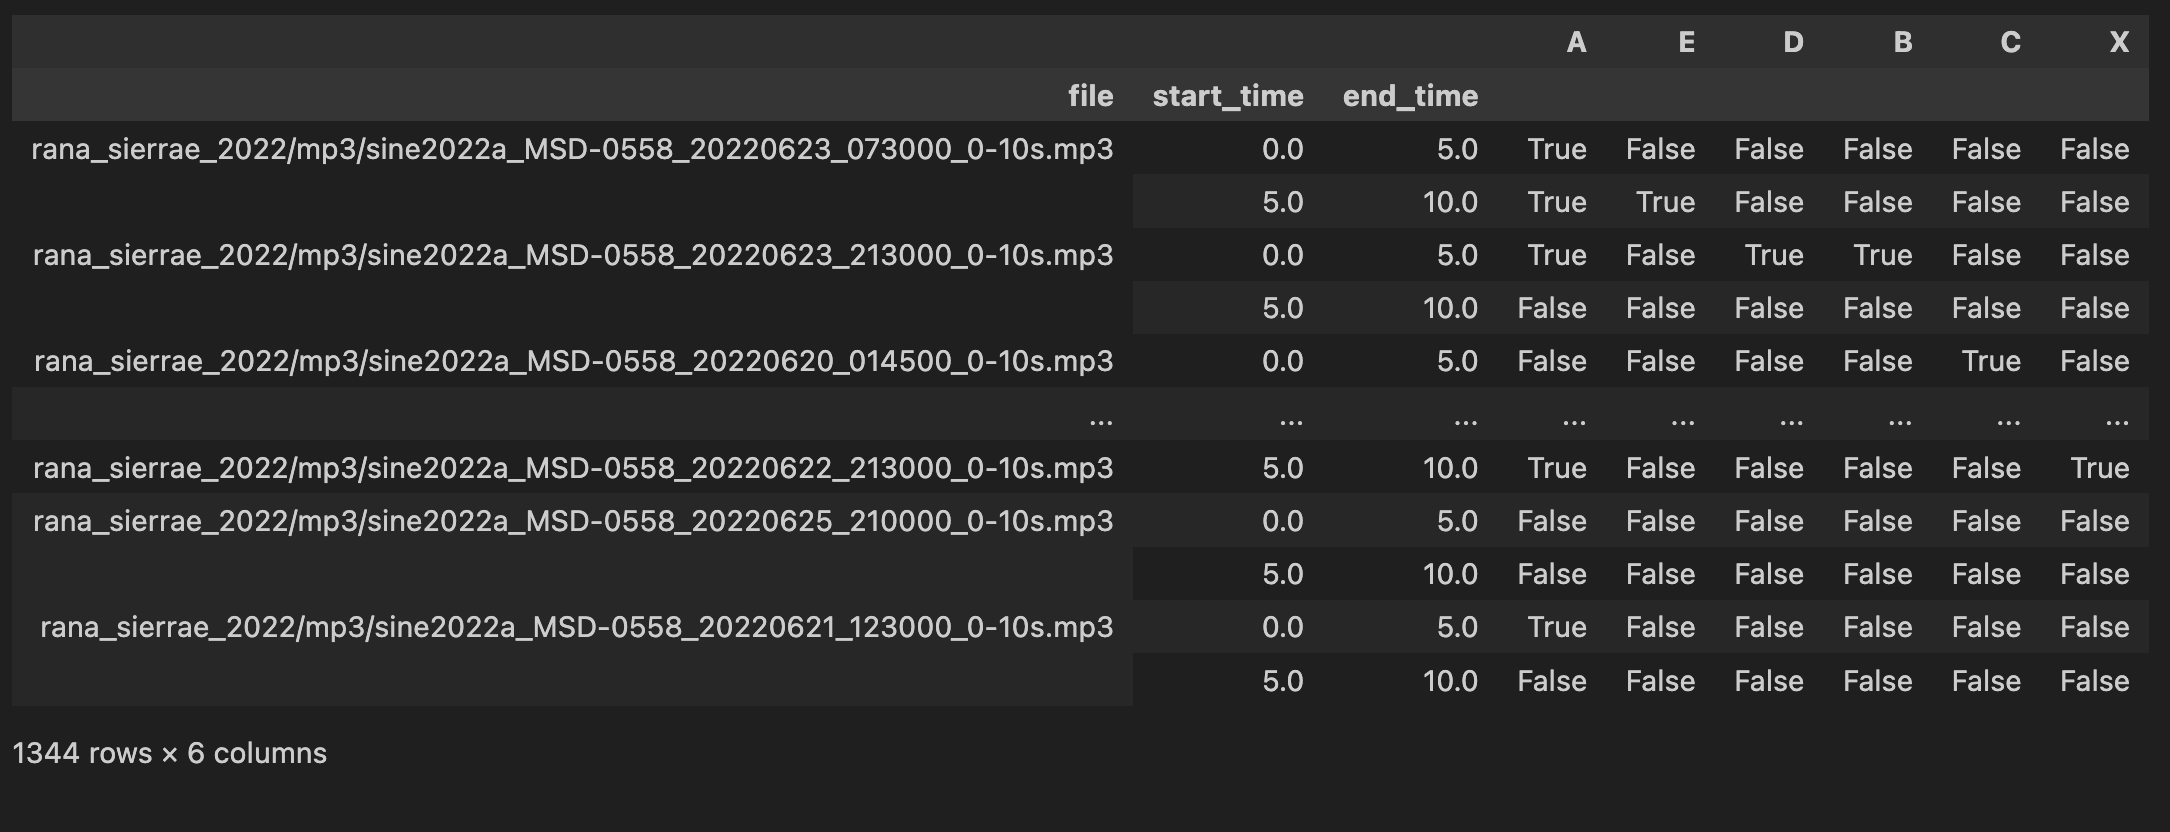